# Module 2 Final Project
* Student: Emily J. Cain
* Date: December 2018
* Instructor: Rafael Carrasco

## Hypothesis 1
* H0 - Discount amount does not have a statistically significant effect on the quantity of the product ordered.
* H1 - Discount amount has a statistically significant effect on the quantity of the product ordered.

### Further Questions
* At what level(s) of discount? (Requirement)
* Does original unit price also have an effect? (Me)

## Hypothesis 2
* H0 - All employees sell about the same amount of products as the other employees. 
* H2 - Some employees sell a significantly greater (or lesser?) amount than other employees. 

### Wait, I only have one mean. . .  

## Hypothesis 3
* H0 -
* H3 -

## Hypothesis 4
* H0 -
* H4 - 

## Ideas
* Does the database show how long a customer has been with the company? Does customer loyalty have an effect on orders? Actionable - target specific customers
* Certain products and their sales - is there a product more popular in a certain regions where we could use targeted advertising? 
* Are there employees with a much higher sales rate than others? Maybe there should be a bonus for making a certain amount of sales. Possibly sort by region?
* What are the most popular products? What about offering sales on certain products - OR! Offering a discount on the products that are _already_ popular if they buy something else or spend a certain amount of money?? Ooohhh
* Are certain products always bought together? Is this something I can even figure out lol?
* Top customers?

In [1]:
# Notes to myself
# Active or passive tone when talking about rejecting the null hypothesis? Be consistent throughout.
# Be able to describe: log transformation, t-statistic, 
# Choose consistent color themes
# Show visualization of where the mean falls on the curve - do you need to divide your p-value by 2? Yes probably

## Establish connection to the database

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression

from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
conn = sqlite3.connect('Northwind_small.sqlite')
c = conn.cursor()

## Grab table names

In [4]:
c.execute("SELECT name FROM sqlite_master WHERE type = 'table';").fetchall()

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

## Create dataframes of each table for initial inspection

In [5]:
employee_df = pd.read_sql_query('SELECT * FROM Employee;', conn)
employee_df.head()

,Id,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,1,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2024-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp
1,2,Fuller,Andrew,"Vice President, Sales",Dr.,1984-02-19,2024-08-14,908 W. Capital Way,Tacoma,North America,98401,USA,(206) 555-9482,3457,None,Andrew received his BTS commercial in 1974 and...,NaN,http://accweb/emmployees/fuller.bmp
2,3,Leverling,Janet,Sales Representative,Ms.,1995-08-30,2024-04-01,722 Moss Bay Blvd.,Kirkland,North America,98033,USA,(206) 555-3412,3355,None,Janet has a BS degree in chemistry from Boston...,2.0,http://accweb/emmployees/leverling.bmp
3,4,Peacock,Margaret,Sales Representative,Mrs.,1969-09-19,2025-05-03,4110 Old Redmond Rd.,Redmond,North America,98052,USA,(206) 555-8122,5176,None,Margaret holds a BA in English literature from...,2.0,http://accweb/emmployees/peacock.bmp
4,5,Buchanan,Steven,Sales Manager,Mr.,1987-03-04,2025-10-17,14 Garrett Hill,London,British Isles,SW1 8JR,UK,(71) 555-4848,3453,None,Steven Buchanan graduated from St. Andrews Uni...,2.0,http://accweb/emmployees/buchanan.bmp


In [6]:
category_df = pd.read_sql_query('SELECT * FROM Category;', conn)
category_df.head()

,Id,CategoryName,Description
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,2,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
2,3,Confections,"Desserts, candies, and sweet breads"
3,4,Dairy Products,Cheeses
4,5,Grains/Cereals,"Breads, crackers, pasta, and cereal"


In [7]:
customer_df = pd.read_sql_query('SELECT * FROM Customer;', conn)
customer_df.head()

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67


In [8]:
shipper_df = pd.read_sql_query('SELECT * FROM Shipper;', conn)
shipper_df.head()

,Id,CompanyName,Phone
0,1,Speedy Express,(503) 555-9831
1,2,United Package,(503) 555-3199
2,3,Federal Shipping,(503) 555-9931


In [9]:
supplier_df = pd.read_sql_query('SELECT * FROM Supplier;', conn)
supplier_df.head()

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,HomePage
0,1,Exotic Liquids,Charlotte Cooper,Purchasing Manager,49 Gilbert St.,London,British Isles,EC1 4SD,UK,(171) 555-2222,None,None
1,2,New Orleans Cajun Delights,Shelley Burke,Order Administrator,P.O. Box 78934,New Orleans,North America,70117,USA,(100) 555-4822,None,#CAJUN.HTM#
2,3,Grandma Kelly's Homestead,Regina Murphy,Sales Representative,707 Oxford Rd.,Ann Arbor,North America,48104,USA,(313) 555-5735,(313) 555-3349,None
3,4,Tokyo Traders,Yoshi Nagase,Marketing Manager,9-8 Sekimai Musashino-shi,Tokyo,Eastern Asia,100,Japan,(03) 3555-5011,None,None
4,5,Cooperativa de Quesos 'Las Cabras',Antonio del Valle Saavedra,Export Administrator,Calle del Rosal 4,Oviedo,Southern Europe,33007,Spain,(98) 598 76 54,None,None


Use square brackets when querying ```[Order]``` due to being a reserved keyword 

In [10]:
order_df = pd.read_sql_query('SELECT * FROM [Order];', conn)
order_df.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [11]:
product_df = pd.read_sql_query('SELECT * FROM Product;', conn)
product_df.head()

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


In [12]:
order_detail_df = pd.read_sql_query('SELECT * FROM OrderDetail;', conn)
order_detail_df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [13]:
customer_customer_demo_df = pd.read_sql_query('SELECT * FROM CustomerCustomerDemo;', conn)
customer_customer_demo_df.head()

,Id,CustomerTypeId


In [14]:
customer_demographic_df = pd.read_sql_query('SELECT * FROM CustomerDemographic', conn)
customer_demographic_df.head()

,Id,CustomerDesc


In [15]:
region_df = pd.read_sql_query('SELECT * FROM Region;', conn)
region_df.head()

,Id,RegionDescription
0,1,Eastern
1,2,Western
2,3,Northern
3,4,Southern


In [16]:
territory_df = pd.read_sql_query('SELECT * FROM Territory;', conn)
territory_df.head()

,Id,TerritoryDescription,RegionId
0,01581,Westboro,1
1,01730,Bedford,1
2,01833,Georgetow,1
3,02116,Boston,1
4,02139,Cambridge,1


In [17]:
employee_territory_df = pd.read_sql_query('SELECT * FROM EmployeeTerritory;', conn)
employee_territory_df.head()

,Id,EmployeeId,TerritoryId
0,1/06897,1,06897
1,1/19713,1,19713
2,2/01581,2,01581
3,2/01730,2,01730
4,2/01833,2,01833


## Hypothesis 1
* H0 - Discount amount does not have a statistically significant effect on the quantity of the product ordered.
* H1 - Discount amount has a statistically significant effect on the quantity of the product ordered.

### Further Questions
* At what level(s) of discount?
* Confidence Intervals?
* Is n large enough?
* Normalize discount distribution? Or is showing normalized quantity enough since I'm only comparing quantities?

### Hypothesis 1 Values
* H0: mu == 21.7 (quantity mean with no discount)
* HA: mu > 21.7 (discount has a statistically significant effect on the quantity ordered)

In [18]:
order_detail_df.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


In [19]:
quantity_discount_df = pd.read_sql_query('SELECT Quantity, Discount FROM OrderDetail', conn)
quantity_discount_df.head()

,Quantity,Discount
0,12,0.0
1,10,0.0
2,5,0.0
3,9,0.0
4,40,0.0


## Finding and Comparing the means
* Create one population of orders with no discount and find the mean
* Create another population of orders with discount and find the mean

In [20]:
c.execute('SELECT COUNT(Quantity) FROM OrderDetail WHERE Discount = 0.0').fetchall()

[(1317,)]

In [21]:
c.execute('SELECT COUNT(Quantity) FROM OrderDetail WHERE Discount != 0.0').fetchall()

[(838,)]

Create two different dataframes with the above queries

In [22]:
no_discount_df = pd.read_sql_query('SELECT Quantity, Discount FROM OrderDetail WHERE Discount = 0.0', conn)
no_discount_df.head()

,Quantity,Discount
0,12,0.0
1,10,0.0
2,5,0.0
3,9,0.0
4,40,0.0


In [23]:
no_discount_df.describe()

,Quantity,Discount
count,1317.000000,1317.0
mean,21.715262,0.0
std,17.507493,0.0
min,1.000000,0.0
25%,10.000000,0.0
50%,18.000000,0.0
75%,30.000000,0.0
max,130.000000,0.0


#### Distribution of Quantity with No Discount

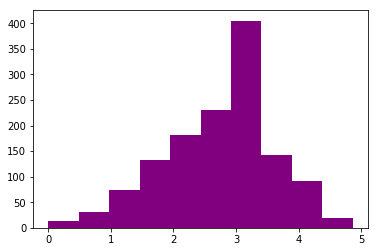

In [24]:
plt.hist(np.log(no_discount_df.Quantity), color='purple');

In [25]:
yes_discount_df = pd.read_sql_query('SELECT Quantity, Discount FROM OrderDetail WHERE Discount != 0.0', conn)
yes_discount_df.head()

,Quantity,Discount
0,35,0.15
1,15,0.15
2,6,0.05
3,15,0.05
4,40,0.05


In [26]:
yes_discount_df.describe()

,Quantity,Discount
count,838.000000,838.000000
mean,27.109785,0.144439
std,20.771439,0.071808
min,1.000000,0.010000
25%,12.000000,0.100000
50%,20.000000,0.150000
75%,36.000000,0.200000
max,130.000000,0.250000


#### Distribution of Quantity with Discount

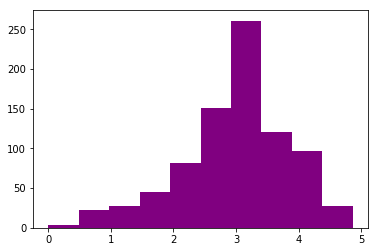

In [27]:
plt.hist(np.log(yes_discount_df.Quantity), color='purple');

In [28]:
mu1 = no_discount_df['Quantity'].mean()
std1 = no_discount_df['Quantity'].std(ddof=0)
print(f'No discount mean = {mu1}')
print(f'No discount standard deviation = {std1}')

No discount mean = 21.715261958997722
No discount standard deviation = 17.500845477669806


In [29]:
mu2 = yes_discount_df['Quantity'].mean()
std2 = yes_discount_df['Quantity'].std(ddof=0)
print(f'Yes discount mean = {mu2}')
print(f'Yes discount standard deviation = {std2}')

Yes discount mean = 27.10978520286396
Yes discount standard deviation = 20.759042075141373


In [48]:
t, p = stats.ttest_ind(no_discount_df['Quantity'], yes_discount_df['Quantity'])
# Divide this p-value by 2 since this is a one-tailed t-test
if p/2 < 0.05:
    print(f'With a p-value of {round(p,3)}, the null hypothesis can be rejected.')
else:
    print(f'With a p-value of {round(p,3)}, the null hypothesis cannot be rejected.')

With a p-value of 0.0, the null hypothesis can be rejected.


## Hypothesis 1 Conclusion
#### With a p-value of 0.0, the null hypothesis that discount does not have a statistically significant effect on the quantity of the product ordered can be rejected.

### Discount amount?

## Exploration of the Data

In [31]:
order_df.dtypes

Id                  int64
CustomerId         object
EmployeeId          int64
OrderDate          object
RequiredDate       object
ShippedDate        object
ShipVia             int64
Freight           float64
ShipName           object
ShipAddress        object
ShipCity           object
ShipRegion         object
ShipPostalCode     object
ShipCountry        object
dtype: object

In [32]:
order_df['OrderDate'] = pd.to_datetime(order_df['OrderDate'])

In [33]:
order_df.dtypes

Id                         int64
CustomerId                object
EmployeeId                 int64
OrderDate         datetime64[ns]
RequiredDate              object
ShippedDate               object
ShipVia                    int64
Freight                  float64
ShipName                  object
ShipAddress               object
ShipCity                  object
ShipRegion                object
ShipPostalCode            object
ShipCountry               object
dtype: object

In [34]:
# order_df.OrderDate.values

The dataset includes products ordered in 2012, 2013, and 2014. 

## Hypothesis 2
* H0 - All employees sell, on average, the same amount of products as the other employees. 
* H2 - Some employees sell a significantly greater (or lesser?) amount than other employees. 

### Hypothesis 2 Values
* H0: mu == 5701.89 (mean for all employees sales)
* HA: mu $\neq$ 5701.89

In [35]:
employee_sales_df = pd.read_sql_query('SELECT EmployeeId, [Order].Id, OrderDetail.Quantity FROM [Order] \
INNER JOIN OrderDetail ON [Order].Id = OrderDetail.OrderId', conn)
employee_sales_df.head()

,EmployeeId,Id,Quantity
0,5,10248,12
1,5,10248,10
2,5,10248,5
3,6,10249,9
4,6,10249,40


In [36]:
employee_sales_df.describe()

,EmployeeId,Id,Quantity
count,2155.000000,2155.000000,2155.000000
mean,4.333179,10659.375870,23.812993
std,2.490351,241.378032,19.022047
min,1.000000,10248.000000,1.000000
25%,2.000000,10451.000000,10.000000
50%,4.000000,10657.000000,20.000000
75%,7.000000,10862.500000,30.000000
max,9.000000,11077.000000,130.000000


#### Distribution of Sales

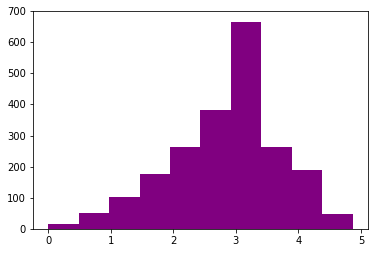

In [47]:
plt.hist(np.log(employee_sales_df.Quantity), color='purple');

In [38]:
# Check SQL statement is correct before making new table
c.execute('SELECT EmployeeId, SUM(OrderDetail.Quantity) FROM [Order] INNER JOIN OrderDetail ON [Order].Id = \
OrderDetail.OrderId GROUP BY EmployeeId;').fetchall()

[(1, 7812),
 (2, 6055),
 (3, 7852),
 (4, 9798),
 (5, 3036),
 (6, 3527),
 (7, 4654),
 (8, 5913),
 (9, 2670)]

In [43]:
total_sales_by_employee_df = pd.read_sql_query('SELECT EmployeeId, SUM(OrderDetail.Quantity) AS Total FROM [Order] \
INNER JOIN OrderDetail ON [Order].Id = OrderDetail.OrderId GROUP BY EmployeeId;', conn)
total_sales_by_employee_df.head()

,EmployeeId,Total
0,1,7812
1,2,6055
2,3,7852
3,4,9798
4,5,3036


In [45]:
sales_mean = round(total_sales_by_employee_df.Total.mean(), 2)
sales_mean

5701.89

### Wait, what am I doing??

## This is Other Stuff that I am not using 

In [74]:
X = quantity_discount_df.iloc[:,1].values
Y = quantity_discount_df.iloc[:,0].values

In [21]:
X.shape

(2155,)

### Visualizing Data

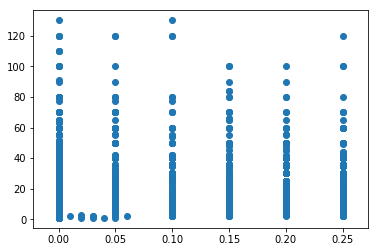

In [22]:
plt.scatter(X, Y);

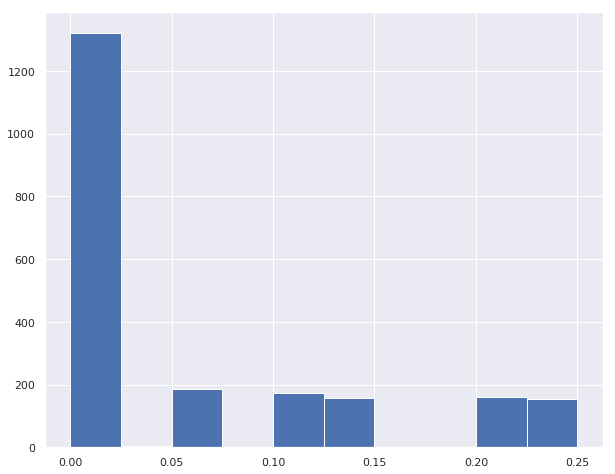

In [78]:
plt.hist(X);

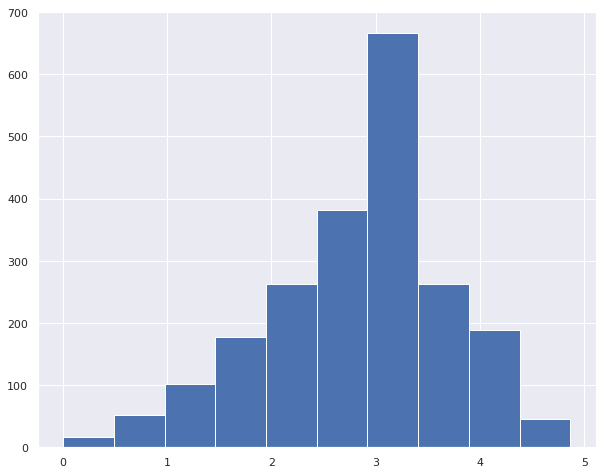

In [76]:
plt.hist(np.log(Y));

In [79]:
log_y = np.log(Y)

In [82]:
from statsmodels import formula
from statsmodels.api import stats
from statsmodels.formula.api import ols

In [84]:
formula = 'log_y ~ X'
lm = ols(formula, quantity_discount_df).fit()
table = stats.anova_lm(lm, typ=2)
table

,sum_sq,df,F,PR(>F)
X,29.447383,1.0,39.232815,4.528435e-10
Residual,1615.999621,2153.0,NaN,NaN


In [85]:
formula = 'Y ~ X'
lm = ols(formula, quantity_discount_df).fit()
table = stats.anova_lm(lm, typ=2)
table

,sum_sq,df,F,PR(>F)
X,12884.989179,1.0,36.191587,2.095888e-09
Residual,766514.647015,2153.0,NaN,NaN


### Initial Model with Holdout Validation

In [25]:
# assigning a random_state guarantees that the results will be the same each time I run this cell
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [26]:
X_train = X_train.reshape(-1,1)
X_train.shape

(1724, 1)

In [27]:
X_test = X_test.reshape(-1,1)
X_test.shape

(431, 1)

In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [29]:
clf = GaussianNB()
clf.fit(X_train_scaled, Y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [30]:
Y_pred = clf.predict(X_test_scaled)

In [31]:
accuracy_score(Y_test, Y_pred)

0.002320185614849188

In [32]:
# WELL THAT'S PRETTY TERRIBLE 

### Just trying Things

In [35]:
# Scale the data using MinMax
scale = MinMaxScaler()
transformed = scale.fit_transform(quantity_discount_df)
trans_dq_df = pd.DataFrame(transformed, columns=quantity_discount_df.columns)
trans_dq_df.head()

/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,Quantity,Discount
0,0.085271,0.0
1,0.069767,0.0
2,0.031008,0.0
3,0.062016,0.0
4,0.302326,0.0


In [36]:
X = trans_dq_df[['Discount']]
y = trans_dq_df['Quantity']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

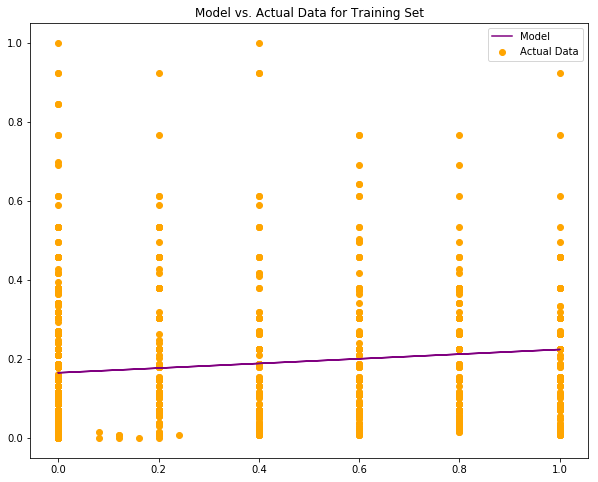

In [41]:
plt.figure(figsize=(10,8))
plt.plot(X_train, linreg.predict(X_train), label='Model', color='purple')
plt.scatter(X_train, y_train, label='Actual Data', color='orange')
plt.title('Model vs. Actual Data for Training Set')
plt.legend()
plt.show();

In [42]:
# WOW THAT IS SO AWESOME 

### HEY HERE'S A THOUGHT WHY DON'T YOU MAKE A CONTROL GROUP 

In [45]:
experimental = trans_dq_df[['Discount']]

In [47]:
experimental.shape

(2155, 1)

In [62]:
control_zs = np.zeros((2155, 1))

In [52]:
control_zs.shape

(2155, 1)

In [54]:
control_randos = np.random.rand(2155,1)

In [55]:
control_randos.shape

(2155, 1)

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


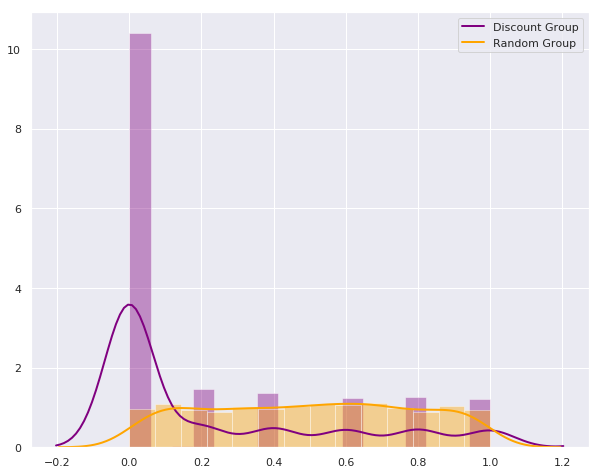

In [63]:
sns.set(rc={'figure.figsize':(10,8)})
sns.distplot(experimental, color='purple', kde_kws={"color": "purple", "lw": 2, "label": "Discount Group"});
sns.distplot(control_randos, color='orange', kde_kws={"color": "orange", "lw": 2, "label": "Random Group"});

In [65]:
# not sure what the purpose of this was
# sns.set(rc={'figure.figsize':(10,8)})
# sns.distplot(experimental, color='purple', kde_kws={"color": "purple", "lw": 2, "label": "Discount Group"});
# sns.distplot(control_zs, color='green', kde_kws={"color": "green", "lw": 2, "label": "Control Zero Group"});

In [66]:
y.describe()

count    2155.000000
mean        0.176845
std         0.147458
min         0.000000
25%         0.069767
50%         0.147287
75%         0.224806
max         1.000000
Name: Quantity, dtype: float64

In [70]:
linreg = LinearRegression()
X_z = control_zs

X_train, X_test, y_train, y_test = train_test_split(X_z, y, test_size = 0.2)
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)